#### Music-conditioned human motion generation using AIST++ dataset

AIST++ dataset contains 1408 sequences of 3D human dance motion, each sequence with duration 7-48 seconds, along with corresponding music.

Task: Flow-matching for generating realistic human dance motion conditioned on a music segment, and potentially on a seed motion sequence.

Input: Segment of music -> embed with some pretrained model

Output: Sequence of 3D Human body keypoints data of shape (N frames x 17 joints x 3 coordinates) following COCO format at 60Fps. (sample visualization below)

<img src="https://github.com/thelmn/flow-diffusion/blob/master/aistpp-dataset-dance-screen.png?raw=1" width="350">

In [1]:
import os
import sys

from pathlib import Path
import glob

In [2]:
import numpy as np
import pickle

import jax
import jax.numpy as jnp

import torch


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# download AIST++ keypoints3d data from https://google.github.io/aistplusplus_dataset/download.html
# download AIST++ music dataset from https://github.com/Garfield-kh/TM2D

In [5]:
# HOME_PATH = Path("data/aist_plusplus")
HOME_PATH = Path("drive/MyDrive/datasets/aist_plusplus")


In [6]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
MUSIC_FOLDER = HOME_PATH / 'all_music'
KEYPOINTS_FOLDER = HOME_PATH / 'keypoints3d'
# MOTIONS_FOLDER = HOME_PATH / 'motions'

music_list = sorted(glob.glob(f'{MUSIC_FOLDER}/*.wav'))
keypoints_list = sorted(glob.glob(f'{KEYPOINTS_FOLDER}/*.pkl'))

print(len(music_list))
print(music_list[:3])
print(len(keypoints_list))
print(keypoints_list[:3])

60
['drive/MyDrive/datasets/aist_plusplus/all_music/mBR0.wav', 'drive/MyDrive/datasets/aist_plusplus/all_music/mBR1.wav', 'drive/MyDrive/datasets/aist_plusplus/all_music/mBR2.wav']
1408
['drive/MyDrive/datasets/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch01.pkl', 'drive/MyDrive/datasets/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch02.pkl', 'drive/MyDrive/datasets/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch03.pkl']


In [8]:
try:
  import librosa
except ImportError:
  !pip install librosa
  import librosa

try:
  import pywt
except ImportError:
  !pip install PyWavelets
  import pywt

try:
  import soundfile as sf
except ImportError:
  !pip install soundfile
  import soundfile as sf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.8 MB/s eta 0:00:00


In [9]:

with open(keypoints_list[0], 'rb') as f:
  sample_keypoints = pickle.load(f)
print(sample_keypoints.keys())
print(sample_keypoints[list(sample_keypoints.keys())[0]].shape)
print(sample_keypoints[list(sample_keypoints.keys())[1]].shape)


dict_keys(['keypoints3d', 'keypoints3d_optim'])
(720, 17, 3)
(720, 17, 3)


##### Embed (and save) music data with pretrained model (MusicFM)

In [10]:
EMBED_MODEL_SR = 24000  # 24kHz
KEYPOINT_FRAME_RATE = 60  # 60 fps

In [11]:
y, sr = librosa.load(music_list[0])
y_len_s = y.shape[0] / sr

print('loaded: ', music_list[0], y.shape, 'sr:', sr, 'len (sec):', y_len_s)

y_resampled = librosa.resample(y, orig_sr=sr, target_sr=EMBED_MODEL_SR)
print(y.shape, y_resampled.shape)
# save
sf.write(HOME_PATH/f'sample_resampled_{EMBED_MODEL_SR}.wav', y_resampled, EMBED_MODEL_SR)

loaded:  drive/MyDrive/datasets/aist_plusplus/all_music/mBR0.wav (1190700,) sr: 22050 len (sec): 54.0
(1190700,) (1296001,)


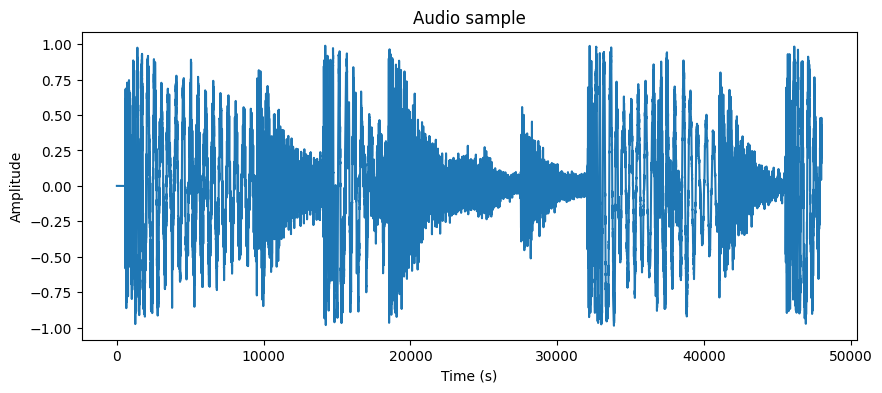

In [12]:
# plot sample
plt.figure(figsize=(10, 4))
plt.plot(y_resampled[:2*EMBED_MODEL_SR])
plt.title('Audio sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# load musicfm model

In [ ]:
!mkdir -p $(pwd)/models/musicfm/data/
!wget -P $(pwd)/models/musicfm/data/ https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
!wget -P $(pwd)/models/musicfm/data/ https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt

--2025-03-31 21:08:18--  https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.121, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2277 (2.2K) [text/plain]
Saving to: ‘/content/models/musicfm/data/msd_stats.json’

msd_stats.json      100%[===================>]   2.22K  --.-KB/s    in 0s      

2025-03-31 21:08:18 (1018 MB/s) - ‘/content/models/musicfm/data/msd_stats.json’ saved [2277/2277]

--2025-03-31 21:08:18--  https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt
Resolving huggingface.co (huggingface.co)... 13.35.202.40, 13.35.202.97, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.40|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/59/f9/59f9da2ff22cce0c5d3661fbe894f143d0a926a238da967e1a4dedf99

In [ ]:
!git clone https://github.com/minzwon/musicfm.git $(pwd)/models/musicfm/musicfm

Cloning into '/content/models/musicfm/musicfm'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 100 (delta 26), reused 18 (delta 18), pack-reused 69 (from 1)
Receiving objects: 100% (100/100), 1.25 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [ ]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
MUSICFM_PATH = './models/musicfm/'
sys.path.append(MUSICFM_PATH)

from musicfm.model.musicfm_25hz import MusicFM25Hz

musicfm = MusicFM25Hz(
    is_flash=False,
    stat_path=os.path.join(MUSICFM_PATH, "data", "msd_stats.json"),
    model_path=os.path.join(MUSICFM_PATH, "data", "pretrained_msd.pt"),
)
musicfm.cuda()
musicfm.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

MusicFM25Hz(
  (preprocessor_melspec_2048): MelSTFT(
    (mel_stft): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
    (amplitude_to_db): AmplitudeToDB()
  )
  (quantizer_melspec_2048_0): RandomProjectionQuantizer()
  (conv): Conv2dSubsampling(
    (conv): Sequential(
      (0): Res2dModule(
        (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv3): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Res2dModule(
        (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), pad

In [ ]:
# embed sample audio file
y_resampled_t = torch.from_numpy(y_resampled.reshape(1, -1))
y_resampled_t = y_resampled_t.cuda()
emb = musicfm.get_latent(y_resampled_t)
print(emb.shape)

plt.figure(figsize=(6, 4))
plt.imshow(emb[0].detach().cpu().numpy().T, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.title('Token embedding')
plt.xlabel('Time')
plt.ylabel('Embedding dimension')
plt.colorbar()
plt.show()

# resample embedding frame rate from 25Hz to 60Hz to match keypoint data
n_frame = int(y_len_s * KEYPOINT_FRAME_RATE)
token_emb = torch.nn.AdaptiveAvgPool1d(n_frame)(emb.transpose(1, 2)).transpose(1, 2)
print(token_emb.shape, token_emb.shape[1] / KEYPOINT_FRAME_RATE)

plt.figure(figsize=(6, 4))
plt.imshow(token_emb[0].detach().cpu().numpy().T, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.title('Token embedding')
plt.xlabel('Time')
plt.ylabel('Embedding dimension')
plt.colorbar()
plt.show()

NameError: name 'torch' is not defined

In [ ]:
for i, music_file in enumerate(music_list):
  y, sr = librosa.load(music_file)
  y_resampled = librosa.resample(y, orig_sr=sr, target_sr=EMBED_MODEL_SR)
  y_len_s = y.shape[0] / sr

  y_resampled_t = torch.from_numpy(y_resampled.reshape(1, -1))
  y_resampled_t = y_resampled_t.cuda()

  emb = musicfm.get_latent(y_resampled_t)
  n_frame = int(y_len_s * KEYPOINT_FRAME_RATE)
  token_emb = torch.nn.AdaptiveAvgPool1d(n_frame)(emb.transpose(1, 2)).transpose(1, 2)

  # save token embedding
  music_name = os.path.basename(music_file).split('.')[0]
  embeds_file = os.path.join(MUSIC_FOLDER, f'{music_name}_musicfm_emb_60Hz.npy')
  np.save(embeds_file, token_emb.detach().cpu().numpy())

  print(f'{i+1}/{len(music_list)}: loaded: {music_file}, {y.shape}, sr: {sr}, len (sec): {y_len_s}. \n'
        f'saved: {embeds_file}, token emb shape: {token_emb.shape}, {token_emb.shape[1] / KEYPOINT_FRAME_RATE} sec')

1/60: loaded: drive/MyDrive/datasets/aist_plusplus/all_music/mBR0.wav, (1190700,), sr: 22050, len (sec): 54.0. 
saved: drive/MyDrive/datasets/aist_plusplus/all_music/mBR0_musicfm_emb_60Hz.npy, token emb shape: torch.Size([1, 3240, 1024]), 54.0 sec
2/60: loaded: drive/MyDrive/datasets/aist_plusplus/all_music/mBR1.wav, (1058400,), sr: 22050, len (sec): 48.0. 
saved: drive/MyDrive/datasets/aist_plusplus/all_music/mBR1_musicfm_emb_60Hz.npy, token emb shape: torch.Size([1, 2880, 1024]), 48.0 sec
3/60: loaded: drive/MyDrive/datasets/aist_plusplus/all_music/mBR2.wav, (873180,), sr: 22050, len (sec): 39.6. 
saved: drive/MyDrive/datasets/aist_plusplus/all_music/mBR2_musicfm_emb_60Hz.npy, token emb shape: torch.Size([1, 2376, 1024]), 39.6 sec
4/60: loaded: drive/MyDrive/datasets/aist_plusplus/all_music/mBR3.wav, (769746,), sr: 22050, len (sec): 34.909115646258506. 
saved: drive/MyDrive/datasets/aist_plusplus/all_music/mBR3_musicfm_emb_60Hz.npy, token emb shape: torch.Size([1, 2094, 1024]), 34.9 

#### To tensorflow dataset

In [74]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def load_dataset_arrs(music_folder, keypoints_folder, load_n):
  music_files = glob.glob(os.path.join(music_folder, '*_musicfm_emb_60Hz.npy'))
  keypoints_files = glob.glob(os.path.join(keypoints_folder, '*.pkl'))
  print(f'Found {len(music_files)} music files and {len(keypoints_files)} keypoints files, loading {load_n} files...')

  music_ids = [os.path.basename(music_file).split('_')[0]
               for music_file in music_files]
  music_ids = dict(zip(music_ids, range(len(music_ids))))

  keypoints = []
  music_embeds = {}
  for keypoints_file in tqdm(keypoints_files[:load_n]):
    filename = os.path.basename(keypoints_file).split('.')[0]
    music_key = filename.split('_')[-2]
    music_file = os.path.join(music_folder, f'{music_key}_musicfm_emb_60Hz.npy')

    if os.path.exists(music_file):
      with open(keypoints_file, 'rb') as f:
        keypoints_data = pickle.load(f)
      keypoints3d_arr = keypoints_data['keypoints3d_optim']
      if music_ids[music_key] not in music_embeds:
        music_embed_arr = np.load(music_file).squeeze()
        music_embeds[music_ids[music_key]] = music_embed_arr
        if np.isnan(music_embed_arr).any():
          print('nan in music_embed_arr')
      keypoints += [(music_ids[music_key], keypoints3d_arr)]
      if np.isnan(keypoints3d_arr).any():
        print('nan in keypoints3d_arr')
  return music_embeds, keypoints

In [75]:
music_embeds, keypoints = load_dataset_arrs(str(MUSIC_FOLDER), str(KEYPOINTS_FOLDER), 100)
print()
print(len(music_embeds), len(keypoints))
print(keypoints[0][0], music_embeds[keypoints[0][0]].shape, keypoints[0][1].shape)

Found 60 music files and 1408 keypoints files, loading 100 files...


100%|██████████| 100/100 [00:00<00:00, 108.46it/s]


22 100
1 (2880, 1024) (640, 17, 3)


In [78]:
def embed_keypoints_gen():
  for music_id, keypoints3d_arr in keypoints:
    yield (music_embeds[music_id][:keypoints3d_arr.shape[0]],
           keypoints3d_arr.reshape(-1, 17*3))

In [79]:
dataset = tf.data.Dataset.from_generator(
    embed_keypoints_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 1024), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 17*3), dtype=tf.float32)
    )
)


In [80]:
for music_embed_arr, keypoints_arr in dataset.take(1):
  print("Music Embedding shape:", music_embed_arr.shape)
  print("Keypoints shape:", keypoints_arr.shape)

Music Embedding shape: (640, 1024)
Keypoints shape: (640, 51)


In [81]:
batch_size = 64
dataset = dataset.padded_batch(
    batch_size, padded_shapes=([None, 1024], [None, 17*3]))


In [82]:
for batch_music_embed_arr, batch_keypoints_arr in dataset.take(1):
  batch_music_embed_arr = batch_music_embed_arr.numpy()
  batch_keypoints_arr = batch_keypoints_arr.numpy()
  print("Batch Music Embedding shape:", batch_music_embed_arr.shape)
  print("Batch Keypoints shape:", batch_keypoints_arr.shape)

Batch Music Embedding shape: (64, 2878, 1024)
Batch Keypoints shape: (64, 2878, 51)


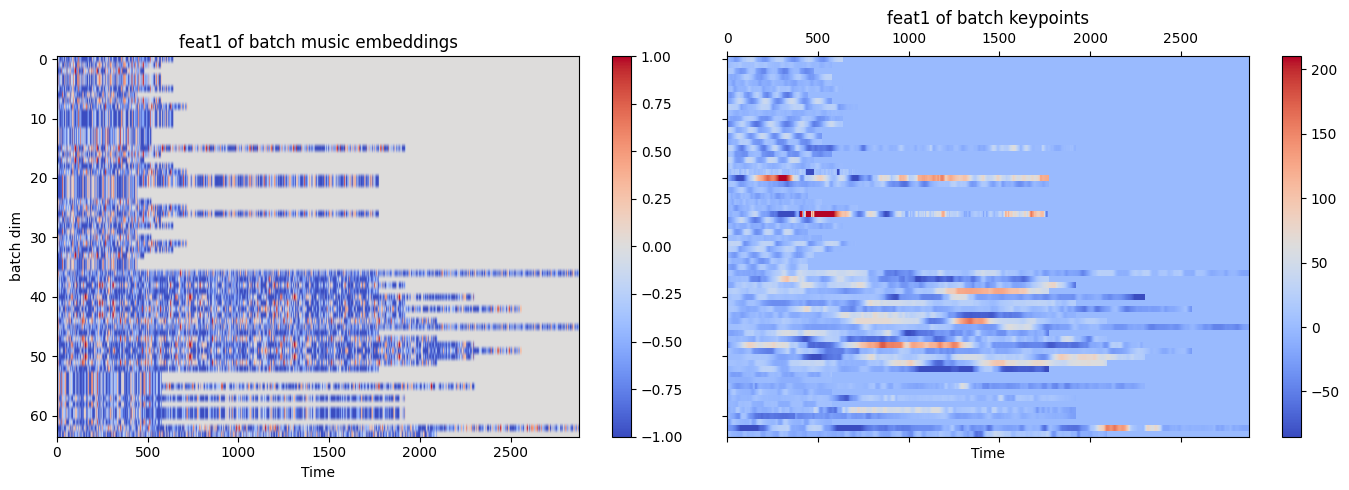

In [86]:
# first music dim of batch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

ax1_plot = ax1.imshow(batch_music_embed_arr[:, :, 0], cmap='coolwarm', vmin=-1,
           vmax=1, aspect='auto')
plt.colorbar(ax1_plot, ax=ax1)
ax1.set_title('feat1 of batch music embeddings')
ax1.set_xlabel('Time')
ax1.set_ylabel('batch dim')

ax2_plot = ax2.matshow(batch_keypoints_arr[:, :, 0], cmap='coolwarm',
            norm='linear',
           vmin=np.quantile(batch_keypoints_arr, 0.01),
           vmax=np.quantile(batch_keypoints_arr, 0.99), aspect='auto')
plt.colorbar(ax2_plot, ax=ax2)
ax2.set_xlabel('Time')
ax2.set_title('feat1 of batch keypoints')


plt.tight_layout()
plt.show()

##### Diffusion transformer

In [ ]:
# Guided Diffusion encoder-only transformer with inputs (X, y, t) where X is the noisy input as a sequence, y is a conditioning sequence of vectors, t is the time step.
# Implementation based on the DiT described in https://arxiv.org/abs/2212.09748 in jax/flax.nnx with a lot of modifications

# Components:
# FeedForward: Dense -> ReLU -> Dropout -> Dense -> Dropout
# TransformerEncoderBlock: in -> LayerNorm -> MultiHeadSelfAttention -> Dropout -> Add(input) -> LayerNorm -> FeedForward -> Add(input) -> out
# ConditionalTransformerEncoderBlock:
#   (in_X, in_y_emb, t_sin_enc) -> \
#     - t_sin_enc -> Dense -> (t_u, t_s)
#     - in_X -> LayerNorm -> ScaleShift(_, t_u, t_s) -> MultiHeadSelfAttention -> Dropout -> Add(_, in_X) -> \
#       -> LayerNorm -> ScaleShift(_, t_u, t_s) -> MultiHeadCrossAttention(_, in_y_emb) -> Dropout -> Add(_, in_X) -> \
#         -> LayerNorm -> ScaleShift(_, t_u, t_s) -> FeedForward -> Add(_, in_X) -> out_X
#     -> out_X
# TransformerEncoder:
#   (X, y, t) -> \
#     - t -> get_sinusoidal_encodings(t) -> t_sin_enc
#     - y -> Dense -> PositionalEncoding -> [ TransformerEncoderBlock x n ] -> LayerNorm -> y_emb
#     - X -> Dense -> PositionalEncoding -> [ ConditionalTransformerEncoderBlock(_, y_emb, t_sin_enc) x n ] -> LayerNorm -> Dense -> out_X
#     -> out_X


import jax
import jax.numpy as jnp
import flax
from flax import nnx
from functools import partial


class FeedForward(nnx.Module):
  def __init__(self, *, in_feats, out_feats=None, hidden_feats=None, dropout=0.0, rngs: nnx.Rngs):
    out_feats = out_feats or in_feats
    hidden_feats = hidden_feats or in_feats
    self.dense1 = nnx.Linear(in_feats, hidden_feats, rngs=rngs)
    self.dense2 = nnx.Linear(hidden_feats, out_feats, rngs=rngs)
    self.dropout = nnx.Dropout(rate=dropout, rngs=rngs)

  def __call__(self, x, train: bool = False):
    x = self.dense1(x)
    x = nnx.relu(x)
    x = self.dropout(x, deterministic=not train)
    x = self.dense2(x)
    x = self.dropout(x, deterministic=not train)
    return x


def get_sinusoidal_encodings(t, embedding_dim):
  half_dim = embedding_dim // 2
  emb = jnp.log(embedding_dim) / (half_dim - 1)
  emb = jnp.exp(jnp.arange(half_dim) * -emb)
  emb = half_dim * t * emb[None, :]
  emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
  return emb


class TransformerEncoderBlock(nnx.Module):
  def __init__(self, *, in_feats, num_heads=8, dropout=0.0, ff_feats_x=4, rngs: nnx.Rngs):
    self.attention = nnx.MultiHeadAttention(
      num_heads=num_heads,
      in_features=in_feats,
      out_features=in_feats,
      dropout_rate=dropout,
      decode=False,
      rngs=rngs)
    self.ff = FeedForward(in_feats=in_feats, hidden_feats=in_feats * ff_feats_x, dropout=dropout, rngs=rngs)
    self.layer_norm1 = nnx.LayerNorm(in_feats, rngs=rngs)
    self.layer_norm2 = nnx.LayerNorm(in_feats, rngs=rngs)
    self.dropout = nnx.Dropout(rate=dropout, rngs=rngs)

  def __call__(self, x, mask=None, train: bool = False):
    x = self.layer_norm1(x)
    x = self.attention(x, mask=mask)
    x = self.dropout(x, deterministic=not train)
    x = x + x
    x = self.layer_norm2(x)
    x = self.ff(x, train=train)
    x = x + x
    return x


class ConditionalTransformerEncoderBlock(nnx.Module):
  def __init__(self, *, in_feats, t_feats, num_heads=8, dropout=0.0, ff_feats_x=4, rngs: nnx.Rngs):
    self.attention = nnx.MultiHeadAttention(
      num_heads=num_heads,
      in_features=in_feats,
      out_features=in_feats,
      dropout_rate=dropout,
      decode=False,
      rngs=rngs)
    self.cross_attention = nnx.MultiHeadAttention(
      num_heads=num_heads,
      in_features=in_feats,
      out_features=in_feats,
      dropout_rate=dropout,
      decode=False,
      rngs=rngs)
    self.ff = FeedForward(in_feats=in_feats, hidden_feats=in_feats * ff_feats_x, dropout=dropout, rngs=rngs)
    self.layer_norm1 = nnx.LayerNorm(in_feats, rngs=rngs)
    self.layer_norm2 = nnx.LayerNorm(in_feats, rngs=rngs)
    self.layer_norm3 = nnx.LayerNorm(in_feats, rngs=rngs)
    self.dropout = nnx.Dropout(rate=dropout, rngs=rngs)
    self.dense_t_u_s = nnx.Linear(t_feats, in_feats * 2, rngs=rngs)

  def __call__(self, x, y_enc, t_sin_enc, mask=None, train: bool = False):
    # x: (batch_size, seq_len, in_feats)
    # y_enc: (batch_size, seq_len, in_feats)
    # t_sin_enc: (batch_size, t_feats)
    # mask: (batch_size, seq_len, seq_len)

    t_u_s = self.dense_t_u_s(t_sin_enc)[:, None, :]  # (batch_size, 1, in_feats * 2)
    t_u, t_s = jnp.split(t_u_s, 2, axis=-1)
    #
    x = self.layer_norm1(x)
    x = (x + t_u) * t_s
    x = self.attention(x, mask=mask)
    x = self.dropout(x, deterministic=not train)
    x = x + x
    #
    x = self.layer_norm2(x)
    x = (x + t_u) * t_s
    x = self.cross_attention(x, y_enc, mask=mask)
    x = self.dropout(x, deterministic=not train)
    x = x + x
    #
    x = self.layer_norm3(x)
    x = (x + t_u) * t_s
    x = self.ff(x, train=train)
    x = x + x
    return x


class AddPositionalEncoding(nnx.Module):
  def __init__(self, *, max_len=512, in_feats=64, rngs: nnx.Rngs):
    self.max_len = max_len
    self.in_feats = in_feats
    self.rngs = rngs
    self.pos_enc = get_sinusoidal_encodings((jnp.arange(max_len)/max_len).reshape(-1, 1), in_feats)
    self.pos_enc = jnp.expand_dims(self.pos_enc, axis=0)  # (1, max_len, in_feats)

  def __call__(self, x):
    # x: (batch_size, seq_len, in_feats)
    # self.pos_enc: (1, max_len, in_feats)
    # return x + self.pos_enc[:, :x.shape[1], :]
    return x + self.pos_enc[:, :x.shape[1], :]


class GuidedDiff_TransfomerEncoder(nnx.Module):
  def __init__(self, *,
               in_feats_X, in_feats_y,
               Xy_feats, out_feats, t_feats=64,
               num_heads=8, num_blocks_X=4, num_blocks_y=2,
               dropout=0.0, ff_feats_x=4, max_len=1024,
               padding_max_value=0,
               rngs: nnx.Rngs):
    self.get_masked_timesteps = lambda y: (y != padding_max_value).sum(axis=-1) > 0
    self.dense_X = nnx.Linear(in_feats_X, Xy_feats, rngs=rngs)
    self.dense_y = nnx.Linear(in_feats_y, Xy_feats, rngs=rngs)
    self.layer_norm_out_X = nnx.LayerNorm(Xy_feats, rngs=rngs)
    self.layer_norm_out_y = nnx.LayerNorm(Xy_feats, rngs=rngs)
    self.get_sin_enc = partial(get_sinusoidal_encodings, embedding_dim=t_feats)
    self.pos_enc_X = AddPositionalEncoding(max_len=max_len, in_feats=Xy_feats, rngs=rngs)
    self.pos_enc_y = AddPositionalEncoding(max_len=max_len, in_feats=Xy_feats, rngs=rngs)
    self.encoders_y = nnx.Sequential(*[
      TransformerEncoderBlock(in_feats=Xy_feats, num_heads=num_heads,
                              dropout=dropout, ff_feats_x=ff_feats_x, rngs=rngs)
      for _ in range(num_blocks_y)
    ])
    self.encoders_X = [ConditionalTransformerEncoderBlock(
      in_feats=Xy_feats, t_feats=t_feats, num_heads=num_heads,
      dropout=dropout, ff_feats_x=ff_feats_x, rngs=rngs)
      for _ in range(num_blocks_X)]
    self.dense_out = nnx.Linear(Xy_feats, out_feats, rngs=rngs)

  def __call__(self, x, y, t, train: bool = False):
    # x: (batch_size, seq_len_X, in_feats_X)
    # y: (batch_size, seq_len_y, in_feats_y)
    # t: (batch_size,)
    # mask inputs where all y values are padding_max_value

    # mask = flax.linen.make_attention_mask(inputs != 0, inputs != 0)
    y_masked = self.get_masked_timesteps(y)
    mask = flax.linen.make_attention_mask(
      y_masked, y_masked, dtype=jnp.float32
    )

    x = self.dense_X(x)
    x = self.pos_enc_X(x)

    y = self.dense_y(y)
    y = self.pos_enc_y(y)
    y = self.encoders_y(y, mask=mask, train=train)
    y = self.layer_norm_out_y(y)

    t = t.reshape(-1, 1)
    t_sin_enc = self.get_sin_enc(t)

    for encoder in self.encoders_X:
      x = encoder(x, y, t_sin_enc, mask=mask, train=train)

    x = self.layer_norm_out_X(x)

    # output -> Dense
    x = self.dense_out(x)

    return x



In [ ]:
# test the model

sample_batch_size = 3
sample_max_sequence_length = 4
sample_feats_X = 6
sample_feats_y = 4
sample_feats_Xy = 10
sample_feats_out = 2
sample_t_feats = 16

key = jax.random.PRNGKey(2)
X_sample = jax.random.normal(key, (sample_batch_size, sample_max_sequence_length, sample_feats_X))
y_sample = jax.random.normal(key, (sample_batch_size, sample_max_sequence_length, sample_feats_y))
t_sample = jax.random.uniform(key, (sample_batch_size,))

# mask some y time steps
y_sample_len = jax.random.randint(key, (sample_batch_size,), minval=1, maxval=sample_max_sequence_length + 1)
y_sample_mask = jnp.arange(sample_max_sequence_length)[None, :] < y_sample_len[:, None]
y_sample = jnp.where(y_sample_mask[:, :, None], y_sample, 0.0)

X_sample.shape, y_sample.shape, t_sample.shape


((3, 4, 6), (3, 4, 4), (3,))

In [ ]:
y = y_sample
y_masked = (y != 0).sum(axis=-1) > 0
mask = flax.linen.make_attention_mask(
  y_masked, y_masked, dtype=jnp.float32
)
mask

Array([[[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]], dtype=float32)

In [ ]:
sample_model = GuidedDiff_TransfomerEncoder(
  in_feats_X=sample_feats_X, in_feats_y=sample_feats_y,
  Xy_feats=sample_feats_Xy, out_feats=sample_feats_out, t_feats=64,
  num_heads=2, num_blocks_X=2, num_blocks_y=2,
  dropout=0.0, ff_feats_x=4, max_len=sample_max_sequence_length,
  padding_max_value=0,
  rngs=nnx.Rngs(42),
)
nnx.display(sample_model)

In [ ]:
X_sample_out = sample_model(X_sample, y_sample, t_sample)
X_sample_out.shape

(3, 4, 2)

In [ ]:
# init actual model
print()


##### Guided conditional flow matching loss

In [ ]:
import optax

def guided_cfm_loss_fn(model, batch_z, batch_y, batch_t, batch_e, train):
  """Compute the conditional flow matching loss."""
  # add noise to the input
  alpha_t = batch_t
  beta_t = (1 - alpha_t)
  batch_x = alpha_t * batch_z + beta_t * batch_e
  pred_e = model(batch_x, batch_y, batch_t, train=train)
  target_e = (batch_z - batch_e)
  loss = optax.losses.squared_error(pred_e, target_e).mean()
  return loss

@nnx.jit
def train_step_guided(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch_z, batch_y, key):
  """Train for a single step."""
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss, grads = nnx.value_and_grad(guided_cfm_loss_fn, argnums=0)(model, batch_z, batch_y, batch_t, batch_e, train=True)
  metrics.update(loss=loss)  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step_guided(model, metrics: nnx.MultiMetric, batch_z, batch_y, key):
  # sample t: [batch_size,1,1,1] ~ Unif[0,1] and e: batch_shape ~ N(0,1)
  batch_t = jax.random.uniform(key, [batch_z.shape[0]] + ([1]*(batch_z.ndim-1)))
  batch_e = jax.random.normal(key, batch_z.shape)

  loss = guided_cfm_loss_fn(model, batch_z, batch_y, batch_t, batch_e, train=False)
  metrics.update(loss=loss)  # In-place updates.

##### Train

In [ ]:
learning_rate = 1e-2
momentum = 0.9

# optax.schedules.cosine_onecycle_schedule(transition_steps: int, peak_value: float, pct_start: float = 0.3, div_factor: float = 25.0, final_div_factor: float = 10000.0)

lr_schedule = optax.schedules.cosine_onecycle_schedule(
  (25)*epoch_steps, peak_value=learning_rate,
  pct_start=5/train_epochs, div_factor=1000, final_div_factor=10.0)

optimizer = nnx.Optimizer(
  model,
  optax.inject_hyperparams(optax.adamw)(lr_schedule, momentum, weight_decay=1e-7),
)
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)
